In [3]:
import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from itertools import count
from collections import Counter

In [4]:
seasonstats1 = pd.read_csv("../data/season_1/stats_season_1.csv")
seasonstats19 = pd.read_csv("../data/season_19/stats_season_19.csv")
seasonstats36 = pd.read_csv("../data/season_36/stats_season_36.csv")

In [8]:
def measuresMerged(seasonstats):
    '''
    PARAMETERS
        seasonstats: DataFrame
            seasonstats is the full imported dataframe of the season statistics
        nodecolor: str
            a column name to color the nodes of the network
        
    RETURNS
        plots a directional graph of each tribal council for each episode during the merged tribal period
    '''
    
    measures = [
        "NumberOfNodes",
        "NumberOfEdges",
        "Density",
        "AverageClusteringCoefficient",
        # "DegreeAssortativityCoefficient",
        "DegreeMin",
        "DegreeMean",
        "DegreeMedian",
        "DegreeMax",
        "ClosenessMin",
        "ClosenessMean",
        "ClosenessMedian",
        "ClosenessMax",
        "BetweenMin",
        "BetweenMean",
        "BetweenMedian",
        "BetweenMax"
    ]
    df = pd.DataFrame(index=pd.Index(measures))
    
    epList = seasonstats[(seasonstats['Merged'] == True)]['Episode'].unique()
    season = str(seasonstats['Season'].unique()[0])
    # tribeName = seasonstats[(seasonstats['Merged'] == True)]['Tribe'].unique()[0]
    lastEp = max(epList)
    
    for i in range(len(epList)):
        if epList[i] != lastEp:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))

            G = nx.DiGraph()
            G.add_edges_from(indvVotes)
            
            df[ep]=getMeasures(G)
        else:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))
            e = []
            
            for i in range(len(indvVotes)):
                if str(indvVotes[i][1]) != 'nan':
                    e.append(indvVotes[i])

            n = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)]['Contestants'].unique()
            
            G = nx.DiGraph()
            G.add_nodes_from(n)
            G.add_edges_from(e)
            df[ep]=getMeasures(G)
    
    return G

In [7]:
def getMeasures(G):
    epMeasures = []
    epMeasures.append(len(list(G.nodes)))
    epMeasures.append(len(list(G.edges)))

    epMeasures.append(nx.density(G))
    epMeasures.append(nx.average_clustering(G))
    # epMeasures.append(nx.degree_assortativity_coefficient(G))


    nodemeasures=np.array(list(dict(nx.degree(G)).values())); #print(x2)
    epMeasures.append(min(nodemeasures))
    epMeasures.append(np.mean(nodemeasures))
    epMeasures.append(np.median(nodemeasures))
    epMeasures.append(max(nodemeasures))

    closemeasures=np.array(list(dict(nx.closeness_centrality(G)).values())); #print(x2)
    epMeasures.append(min(closemeasures))
    epMeasures.append(np.mean(closemeasures))
    epMeasures.append(np.median(closemeasures))
    epMeasures.append(max(closemeasures))

    betweenmeasures=np.array(list(dict(nx.betweenness_centrality(G)).values())); #print(x2)
    epMeasures.append(min(betweenmeasures))
    epMeasures.append(np.mean(betweenmeasures))
    epMeasures.append(np.median(betweenmeasures))
    epMeasures.append(max(betweenmeasures))
    return epMeasures

In [12]:
G1 = measuresMerged(seasonstats1)
G19 = measuresMerged(seasonstats19)
G36 = measuresMerged(seasonstats36)

In [20]:
def allVotes(seasonstats):
    d = seasonstats[['Contestants','TCV']].dropna()
    y = list(d.itertuples(index=False, name=None))
    p = list(Counter(y).items())

    allVotesAttr = {}

    for i in range(len(p)):
        tmp = {}
        allVotesAttr[p[i][0]] = tmp

        tmp["NumVotes"] = p[i][1]

    G = nx.DiGraph()
    fig = plt.figure(figsize=(15, 10))

    G.add_nodes_from(d["Contestants"].unique())
    G.add_edges_from(y)

    widths = list(nx.get_edge_attributes(G,'NumVotes').values())
    n_color = list(nx.get_node_attributes(G,'Sex').values())

    nx.set_edge_attributes(G, allVotesAttr)
    nx.set_node_attributes(G, getNodeAttributes(seasonstats))


    plt.title('End of Season Aggregated Voting History')
    pos=nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, 
            # width=widths
           )

    return G

In [16]:
def getNodeAttributes(seasonstats):
    f = seasonstats[seasonstats['Episode'] == 1][["Contestants","Sex","Age","Occupation","Home State", "Original Tribe"]]
    c = list(f.columns)[1:]
    
    attr = {}

    for i in range(len(f)):
        tmp = {}
        attr[f.iloc[i][0]] = tmp

        for j in range(len(c)):
            tmp[c[j]] = f.iloc[i][j+1] 
            
    return attr
    

In [62]:
def network_summary(G):
    measures=[]
    def centrality_stats(x):
        # measures=[]
        x1=dict(x)
        x2=np.array(list(x1.values())); #print(x2)
        print("	min:" ,min(x2))
        measures.append(min(x2))
        print("	mean:" ,np.mean(x2))
        measures.append(np.mean(x2))
        print("	median:" ,np.median(x2))
        measures.append(np.median(x2))
        # print("	mode:" ,stats.mode(x2)[0][0])
        print("	max:" ,max(x2))
        measures.append(max(x2))
        x=dict(x)
        sort_dict=dict(sorted(x1.items(), key=lambda item: item[1],reverse=True))
        print("	top nodes:",list(sort_dict)[0:6])
        print("	          ",list(sort_dict.values())[0:6])

    try: 
        print("GENERAL")
        print("	number of nodes:",len(list(G.nodes)))
        measures.append(len(list(G.nodes)))
        print("	number of edges:",len(list(G.edges)))
        measures.append(len(list(G.edges)))

        print("	is_directed:", nx.is_directed(G))
        print("	is_weighted:" ,nx.is_weighted(G))
        # print("	is_connected:" ,nx.is_connected(G))
        print("	is_tree:" ,nx.is_tree(G))
        # print("	number_connected_components", nx.number_connected_components(G))
        # print("	number of triangle: ",len(nx.triangles(G).keys()))
        print("	density:" ,nx.density(G))
        measures.append(nx.density(G))
        print("	average_clustering coefficient: ", nx.average_clustering(G))
        measures.append(nx.average_clustering(G))
        print("	degree_assortativity_coefficient: ", nx.degree_assortativity_coefficient(G))
        measures.append(nx.degree_assortativity_coefficient(G))

        # if(nx.is_connected(G)):
        #     print("	diameter:" ,nx.diameter(G))
        #     print("	radius:" ,nx.radius(G))
        #     print("	average_shortest_path_length: ", nx.average_shortest_path_length(G))

        #CENTRALITY 
        print("DEGREE")
        centrality_stats(nx.degree_centrality(G))
        # centrality_stats(nx.degree(G))

        print("CLOSENESS CENTRALITY")
        centrality_stats(nx.closeness_centrality(G))

        print("BETWEEN CENTRALITY")
        centrality_stats(nx.betweenness_centrality(G))
    except:
        print("unable to run")
        
    return measures

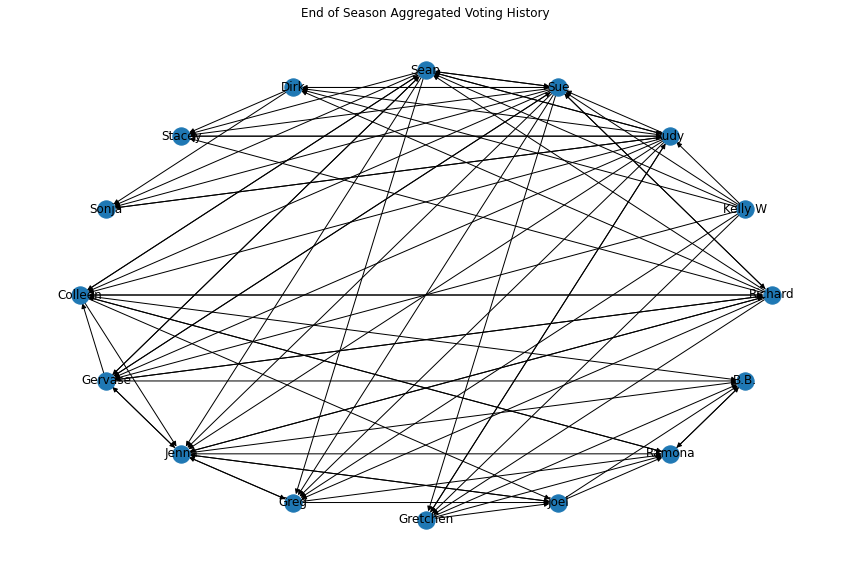

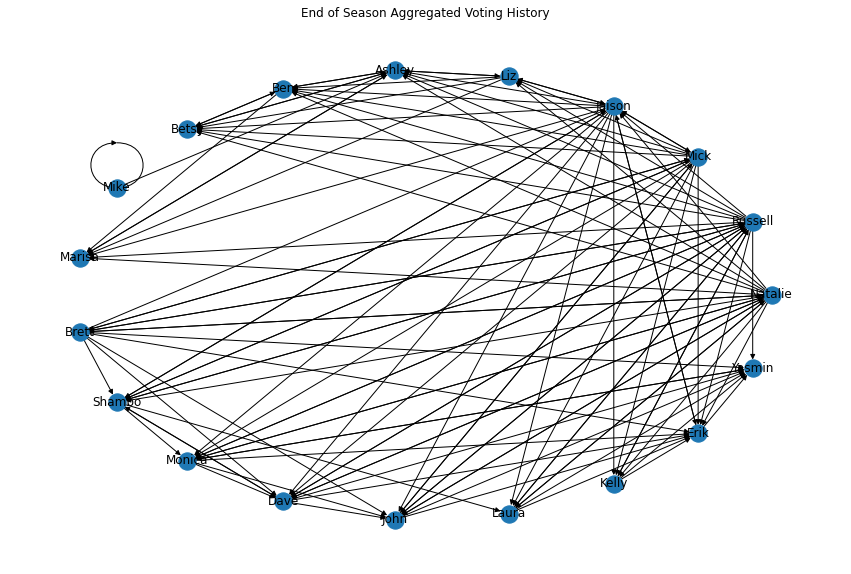

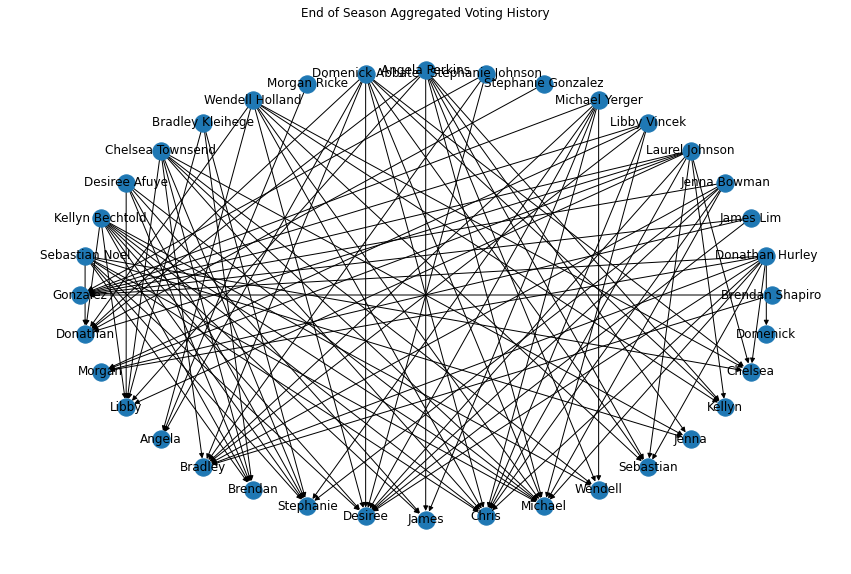

In [32]:
s1 = allVotes(seasonstats1)
s19 = allVotes(seasonstats19)
s36 = allVotes(seasonstats36)

In [63]:
nx.degree_centrality(s1)

{'Richard': 0.8666666666666667,
 'Kelly W': 0.4666666666666667,
 'Rudy': 1.0,
 'Sue': 1.0666666666666667,
 'Sean': 0.9333333333333333,
 'Dirk': 0.4666666666666667,
 'Stacey': 0.4,
 'Sonja': 0.3333333333333333,
 'Colleen': 0.8,
 'Gervase': 0.8,
 'Jenna': 0.9333333333333333,
 'Greg': 0.6,
 'Gretchen': 0.5333333333333333,
 'Joel': 0.4666666666666667,
 'Ramona': 0.5333333333333333,
 'B.B.': 0.4666666666666667}

In [64]:
m1 = network_summary(s1)
m19 = network_summary(s19)
m36 = network_summary(s36)

GENERAL
	number of nodes: 16
	number of edges: 80
	is_directed: True
	is_weighted: False
	is_tree: False
	density: 0.3333333333333333
	average_clustering coefficient:  0.4302594944502999
	degree_assortativity_coefficient:  -0.06570892528953329
DEGREE
	min: 0.3333333333333333
	mean: 0.6666666666666667
	median: 0.5666666666666667
	max: 1.0666666666666667
	top nodes: ['Sue', 'Rudy', 'Sean', 'Jenna', 'Richard', 'Colleen']
	           [1.0666666666666667, 1.0, 0.9333333333333333, 0.9333333333333333, 0.8666666666666667, 0.8]
CLOSENESS CENTRALITY
	min: 0.0
	mean: 0.49597855817182257
	median: 0.5086206896551724
	max: 0.6521739130434783
	top nodes: ['Jenna', 'Colleen', 'Sean', 'Gervase', 'Greg', 'Ramona']
	           [0.6521739130434783, 0.625, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556]
BETWEEN CENTRALITY
	min: 0.0
	mean: 0.061011904761904774
	median: 0.03904761904761905
	max: 0.1743650793650794
	top nodes: ['Rudy', 'Colleen', 'Richard', 'Jenna', 'Sean', 'Ra

In [65]:
measures_names = [
        "Season",
        "NumberOfNodes",
        "NumberOfEdges",
        "Density",
        "AverageClusteringCoefficient",
        "DegreeAssortativityCoefficient",
        "DegreeMin",
        "DegreeMean",
        "DegreeMedian",
        "DegreeMax",
        "ClosenessMin",
        "ClosenessMean",
        "ClosenessMedian",
        "ClosenessMax",
        "BetweenMin",
        "BetweenMean",
        "BetweenMedian",
        "BetweenMax"
    ]

In [66]:
d = {'Season 1':m1,'Season 19':m19, 'Season 36':m36}
df = pd.DataFrame(d).T
df = df.reset_index(level=0)
df.columns = measures_names

In [67]:
df

,Season,NumberOfNodes,NumberOfEdges,Density,AverageClusteringCoefficient,DegreeAssortativityCoefficient,DegreeMin,DegreeMean,DegreeMedian,DegreeMax,ClosenessMin,ClosenessMean,ClosenessMedian,ClosenessMax,BetweenMin,BetweenMean,BetweenMedian,BetweenMax
0,Season 1,16.0,80.0,0.333333,0.430259,-0.065709,0.333333,0.666667,0.566667,1.066667,0.0,0.495979,0.508621,0.652174,0.0,0.061012,0.039048,0.174365
1,Season 19,19.0,114.0,0.333333,0.420266,-0.174196,0.166667,0.666667,0.666667,1.222222,0.0,0.458889,0.461538,0.642857,0.0,0.062607,0.020635,0.301058
2,Season 36,36.0,104.0,0.082540,0.000000,-0.077044,0.028571,0.165079,0.157143,0.285714,0.0,0.082540,0.014286,0.285714,0.0,0.000000,0.000000,0.000000


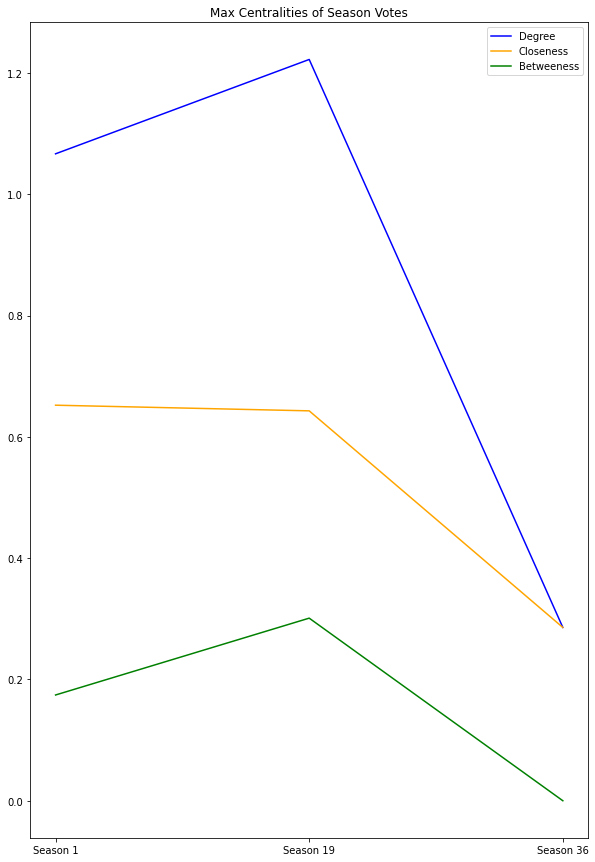

In [74]:
plt.figure(figsize=(15,15))
plt.plot(df['Season'], df['DegreeMax'], color = 'b',label='Degree')
plt.plot(df['Season'], df['ClosenessMax'], color = 'orange',label='Closeness')
plt.plot(df['Season'], df['BetweenMax'], color = 'g', label='Betweeness')
plt.title("Max Centralities of Season Votes")
plt.legend(loc="upper right")
plt.show()